In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

C:\Users\rohit\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
    from sklearn.base import BaseEstimator, TransformerMixin
    
    class rgb2gray_transform(BaseEstimator,TransformerMixin):
        import skimage.color
        def __init__(self):
            pass
        
        def fit(self,X,y=None):
            return self
        
        def transform(self,X,y=None):
            return np.array([skimage.color.rgb2gray(x) for x in X])
        
        
    class hogtransformer(BaseEstimator,TransformerMixin):
        import skimage.feature
        def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
            self.orientations = orientations
            self.pixels_per_cell = pixels_per_cell
            self.cells_per_block = cells_per_block
            
            
        def fit(self,X,y=None):
            return self
        
        def transform(self,X,y=None):
            def local_hog(img):
                hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                    pixels_per_cell=self.pixels_per_cell,
                                    cells_per_block=self.cells_per_block)
                
                return hog_features
            
            hfeatures = np.array([local_hog(x) for x in X])
            return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# pipeline model
image = skimage.io.imread('eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [5]:
feature_vector

array([0.19801825, 0.14617992, 0.12000975, ..., 0.0459591 , 0.04528046,
       0.00672236])

In [6]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [7]:
feature_vector.shape

(3240,)

In [8]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [9]:
result

array(['eagle'], dtype='<U8')

In [11]:
#calculate the probability 
decision_value=model.decision_function(scalex)

In [12]:
decision_value

array([[-185.02611619, -183.03121505, -117.5273228 , -164.96992105,
        -241.93165245, -158.31304776,   -6.43983409,   38.85441849,
        -216.00548115, -148.89556303, -257.74192181,  -91.06720439,
        -221.63287369, -177.96634126,  -83.33553412,  -64.76372862,
        -172.52901339, -175.8943202 , -169.06071197, -301.48957273]])

In [31]:
labels = model.classes_

In [30]:
decision_value = decision_value.flatten()

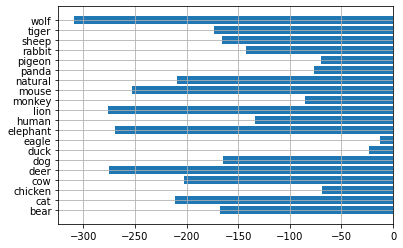

In [35]:
plt.barh(labels,decision_value)
plt.grid()

In [37]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.03000827, 0.01800691, 0.09473694, 0.01997421, 0.00851442,
       0.0308835 , 0.16170897, 0.18217969, 0.00909048, 0.04457203,
       0.00841702, 0.07811273, 0.01103387, 0.01828316, 0.08662433,
       0.09341782, 0.04000368, 0.03070585, 0.02798382, 0.00574228])

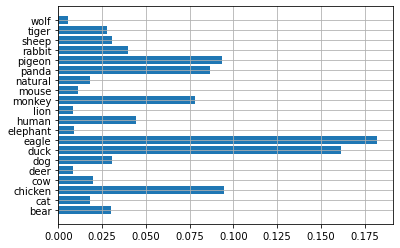

In [38]:
plt.barh(labels,prob_value)
plt.grid()

In [47]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [48]:
top_5_prob_ind

array([ 7,  6,  2, 15, 14], dtype=int64)

In [50]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [52]:
top_prob,top_labels

(array([0.18217969, 0.16170897, 0.09473694, 0.09341782, 0.08662433]),
 array(['eagle', 'duck', 'chicken', 'pigeon', 'panda'], dtype='<U8'))

In [57]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [58]:
top_dict

{'eagle': 0.182,
 'duck': 0.162,
 'chicken': 0.095,
 'pigeon': 0.093,
 'panda': 0.087}

In [60]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [61]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.182,
 'duck': 0.162,
 'chicken': 0.095,
 'pigeon': 0.093,
 'panda': 0.087}